# Import Library

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Preprocess Data

In [2]:
data = pd.read_csv("C:/Users/swongjumras/OneDrive - Deloitte (O365D)/Desktop/titanic/titanic_train.csv")
test = pd.read_csv("C:/Users/swongjumras/OneDrive - Deloitte (O365D)/Desktop/titanic/titanic_test.csv")
test_ids = test["PassengerId"]
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(data.isnull().sum())
print("Duplicated: ",data["PassengerId"].duplicated().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Duplicated:  0


<AxesSubplot:xlabel='Survived', ylabel='count'>

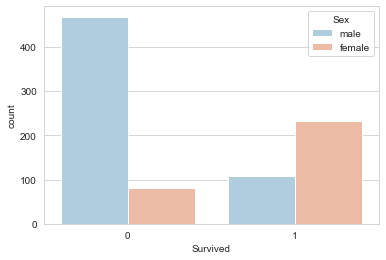

In [4]:
# Survivors by sex
sns.set_style('whitegrid')
sns.countplot(x = 'Survived', hue = 'Sex', data = data, palette = 'RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

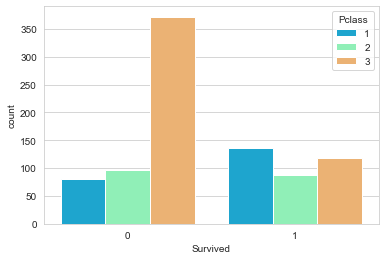

In [5]:
# Survivors by Pclass
sns.set_style('whitegrid')
sns.countplot(x = 'Survived', hue = 'Pclass', data = data, palette = 'rainbow')

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

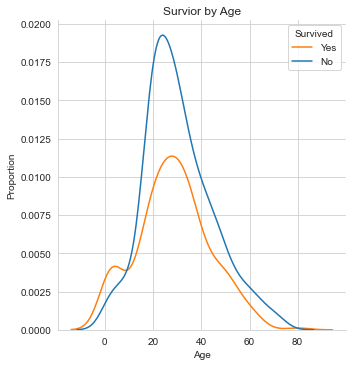

In [6]:
# Survivors by Age
dist = sns.displot(data = data, x ="Age", hue = "Survived", kind ='kde', legend = False)
plt.title("Survior by Age")
plt.xlabel("Age")
plt.ylabel("Proportion") 
plt.legend(title='Survived', labels=["Yes","No"])
data["Age"].describe()

<AxesSubplot:xlabel='SibSp', ylabel='count'>

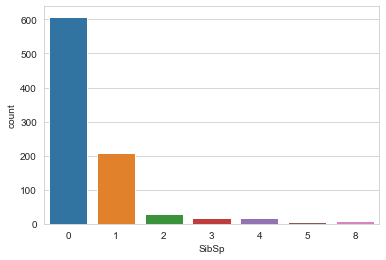

In [7]:
# No. of SibSp
sns.countplot(x='SibSp',data=data)

<AxesSubplot:>

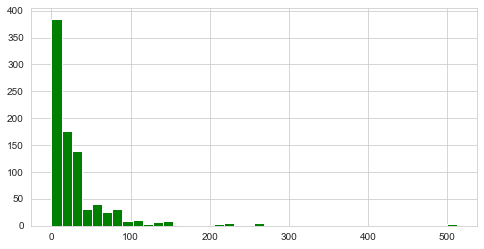

In [8]:
# Distribution of fare
data['Fare'].hist(color='green',bins=40,figsize=(8,4))

Text(0, 35.61176470588235, '34.61')
Text(1, 42.28138613861386, '41.28')
Text(2, 29.722972972972972, '28.72')


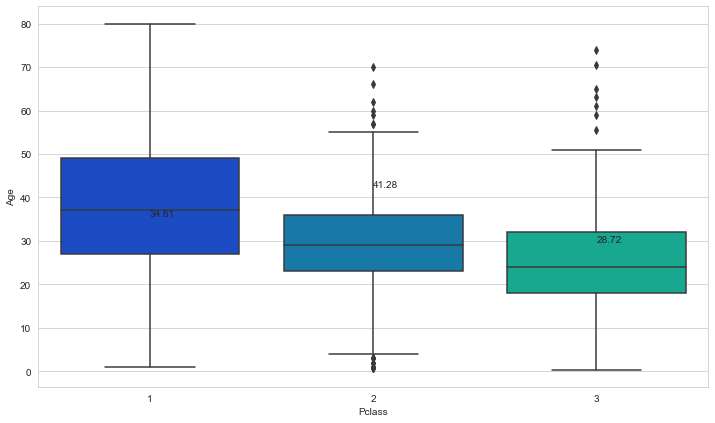

In [9]:
# Check average age by passenger class
plt.figure(figsize=(12,7))
testPlot = sns.boxplot(x='Pclass',y='Age',data=data,palette='winter')

m1 = data.groupby(['Pclass', 'Sex'])['Age'].mean().values
mL1 = [str(np.round(s, 2)) for s in m1]
p1 = range(len(m1))

for tick, label in zip(p1, testPlot.get_xticklabels()):
    print(testPlot.text(p1[tick], m1[tick] + 1, mL1[tick]))

In [10]:
# Count value in Embarked
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

# Feature Engineering

In [11]:
# Fill age data with mean by Pclass
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        
        if Pclass == 1:
            return 34.61
        
        elif Pclass == 2:
            return 41.28
        
        else:
            return 28.72
        
    else:
        return Age

In [12]:
# Drop unnecessary columns and fill null values
def clean(data):
    data = data.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1)
    
    cols1 = ["Fare", "Age"]
    for col in cols1:
        data[col].fillna(data[col].median(), inplace = True)
        
    data["Embarked"].fillna("S", inplace = True)
    return data

data = clean(data)
test = clean(test)

In [13]:
# get_dummies is the option to go with as it would give equal weightage to the categorical variables. 
# LabelEncoder is used when the categorical variables are ordinal i.e. 
# if you are converting severity or ranking, then LabelEncoding "High" as 2 and "low" as 1 would make sense.
# dummies = ['fare', 'age', 'embarked', 'sex']
# dummy_data = pd.get_dummies(data_5[dummies])
# data_6 = pd.concat([data_5, dummy_data], axis = 1)
# data_6.drop(dummies, axis=1, inplace=True)
# Apply label encoder
le = preprocessing.LabelEncoder()

cols_le = ["Sex","Embarked"]

for col in cols_le:
    data[col] = le.fit_transform(data[col])
    test[col] = le.transform(test[col])
    print(le.classes_)
    
data.head()

['female' 'male']
['C' 'Q' 'S']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


Text(0.5, 1.0, 'pearson correlation')

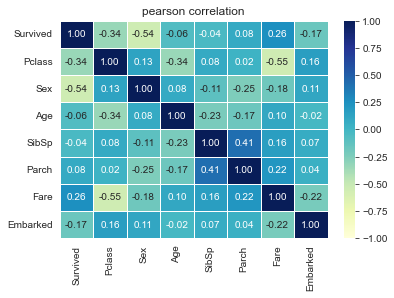

In [14]:
corr_matrix = data.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In [15]:
# Train Test Split
x = data.drop("Survived", axis = 1)
y = data["Survived"]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 33)

# Train a Model

In [40]:
# Assess models
lr = LogisticRegression()
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
gbc = ensemble.GradientBoostingClassifier()
svc = SVC(probability = True)
models = [lr,rfc,dtc,gbc,svc]

In [41]:
for model in models:
    model.fit(x_train, y_train)
    score = model.score(x_val, y_val)
    scores = cross_val_score(model, x_val, y_val, cv = 5, scoring = 'accuracy')
    kf_cv_scores = cross_val_score(model, x_train, y_train, cv=5 )
    accuracy = metrics.accuracy_score(y_val, prediction)
    auc = metrics.roc_auc_score(y_val, prediction)
    print(model,":")
    print("Score: ", score)
    print("Mean cross-validation score: %.2f" % scores.mean())
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("-------------------------------------------------------------------------------------")    

C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

LogisticRegression() :
Score:  0.8044692737430168
Mean cross-validation score: 0.80
K-fold CV average score: 0.80
Accuracy (overall correct predictions): 0.83
Auc: 0.81
-------------------------------------------------------------------------------------
RandomForestClassifier() :
Score:  0.8268156424581006
Mean cross-validation score: 0.82
K-fold CV average score: 0.81
Accuracy (overall correct predictions): 0.83
Auc: 0.81
-------------------------------------------------------------------------------------
DecisionTreeClassifier() :
Score:  0.8212290502793296
Mean cross-validation score: 0.74
K-fold CV average score: 0.77
Accuracy (overall correct predictions): 0.83
Auc: 0.81
-------------------------------------------------------------------------------------
GradientBoostingClassifier() :
Score:  0.8324022346368715
Mean cross-validation score: 0.80
K-fold CV average score: 0.80
Accuracy (overall correct predictions): 0.83
Auc: 0.81
--------------------------------------------------

In [26]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 120, 150],
    'max_features': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500, 700, 1000, 1500]
}
rfc = RandomForestClassifier(random_state = 234)
rfc.fit(x_train,y_train)
# Instantiate the grid search model
rfc_grid = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
rfc_grid.fit(x_train, y_train)
rfc_grid.best_params_

Fitting 5 folds for each of 4536 candidates, totalling 22680 fits


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [33]:
best_grid = rfc_grid.best_estimator_

In [34]:
prediction = best_grid.predict(x_val)

In [36]:
scores = cross_val_score(best_grid, x_val, y_val, cv = 5, scoring = 'accuracy')
kf_cv_scores = cross_val_score(best_grid, x_train, y_train, cv=5 )
accuracy = metrics.accuracy_score(y_val, prediction)
auc = metrics.roc_auc_score(y_val, prediction)
print("-------------------------------------------------------------------------------------")    
print(best_grid,":")
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
print("-------------------------------------------------------------------------------------")    

-------------------------------------------------------------------------------------
RandomForestClassifier(max_depth=80, max_features=6, min_samples_leaf=4,
                       min_samples_split=8, random_state=234) :
Mean cross-validation score: 0.82
K-fold CV average score: 0.82
Accuracy (overall correct predictions): 0.83
Auc: 0.81
-------------------------------------------------------------------------------------


# Evaluate a Model

In [37]:
accuracy = metrics.accuracy_score(y_val, prediction)
auc = metrics.roc_auc_score(y_val, prediction)
scores = cross_val_score(best_grid, x_val, y_val, cv = 10, scoring = 'accuracy')
print("Cross-validation scores:", scores)
print("-------------------------------------------------------------------------------------")
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("-------------------------------------------------------------------------------------")
print("Auc:", round(auc,2))
print("-------------------------------------------------------------------------------------")    

recall = metrics.recall_score(y_val, prediction)
precision = metrics.precision_score(y_val, prediction)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_val, prediction, target_names=[str(i) for i in np.unique(y_val)]))

Cross-validation scores: [0.61111111 0.77777778 0.61111111 1.         0.72222222 0.72222222
 0.72222222 0.88888889 0.83333333 0.94117647]
-------------------------------------------------------------------------------------
Accuracy (overall correct predictions): 0.83
-------------------------------------------------------------------------------------
Auc: 0.81
-------------------------------------------------------------------------------------
Recall (all 1s predicted right): 0.71
Precision (confidence when predicting a 1): 0.85
Detail:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       107
           1       0.85      0.71      0.77        72

    accuracy                           0.83       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



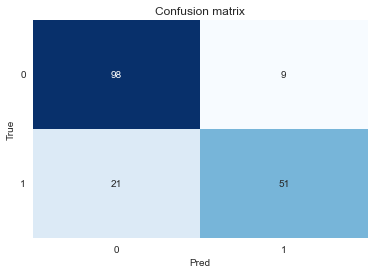

In [38]:
classes = np.unique(y_val)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_val, prediction, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [42]:
submission_predict = rfc_grid.predict(test)
df = pd.DataFrame({"PassengerId": test_ids.values,
                   "Survived": submission_predict})
df.to_csv("C:/Users/swongjumras/OneDrive - Deloitte (O365D)/Desktop/titanic/titanic_submission_rfc.csv", index = False)